# Домашняя работа: "Методы оптимизации"

ФИО: Бабенко Максим Денисович

## Описание задания:
Вам необходимо реализовать оставшиеся методы оптимизации, которые разбирались на лекции: <b>Momentum, AdaDelta, Adam</b>. Сравнение методов оптимизации нужно провести на примере из семинара, а также при обучении сверточной нейронной сети на датасете MNIST.



## Задание разделено на следующие части:
1.1 Реализация методов Momentum, AdaDelta, Adam **(1 балл)**

1.2 Сравнение реализованных методов **(1 балл)**

2.1 Реализация сверточной нейронной сети и обучение ее на MNIST **(2 балла)**

2.2 Сравнение графиков обучения для нейросети на реализованных методах **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 10 октября.

In [4]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

## Часть 1: Реализация методов

In [6]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

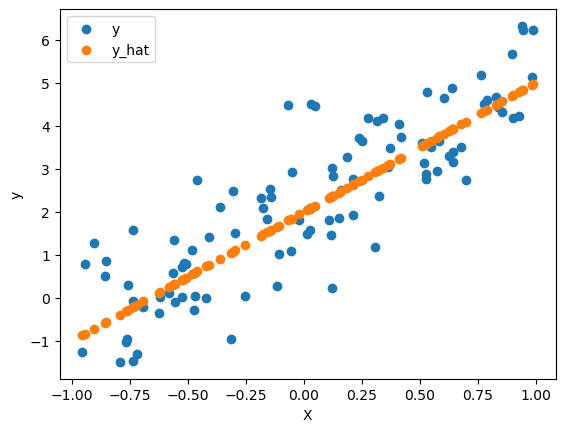

In [7]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

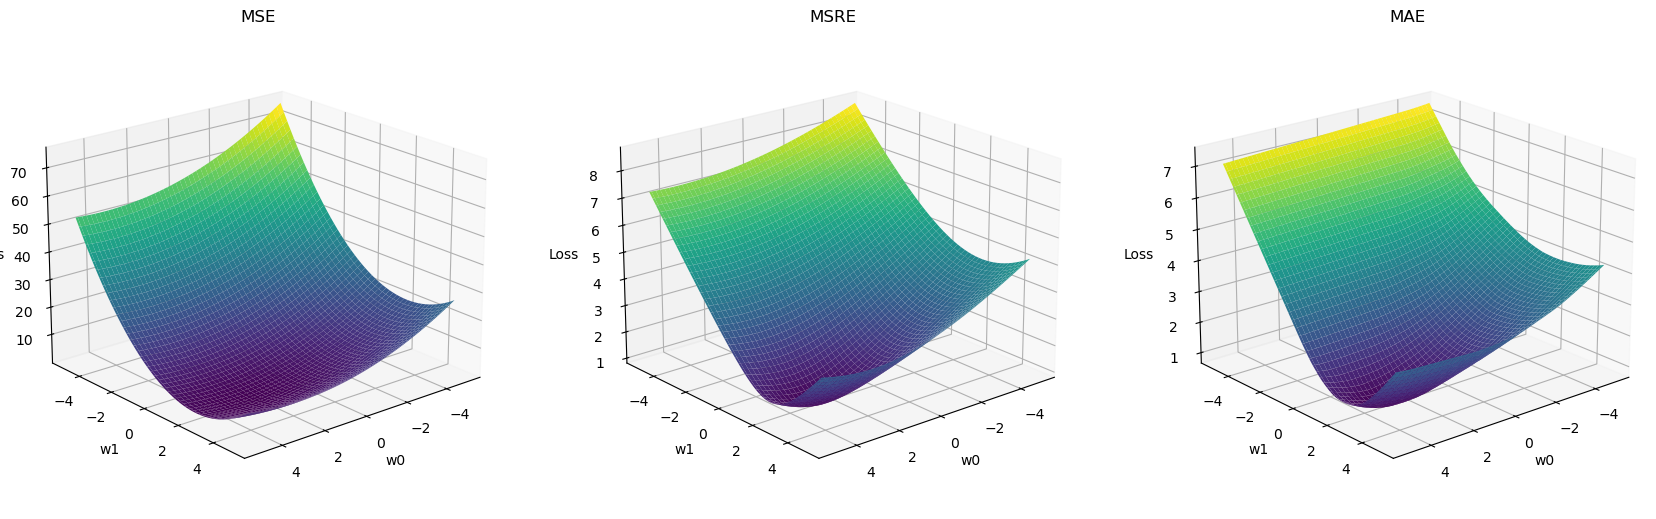

In [8]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [9]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [10]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [11]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

Реализация методов SGD и AdaGrad с семинара:

In [13]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

In [14]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [0] * len(self.params)

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] += p.grad ** 2

                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

### 1.1 Реализуйте методы Momentum, AdaDelta, Adam. **(1 балл)**

#### Momentum
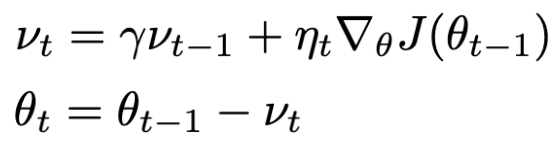

In [17]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.velocity = [torch.zeros_like(p) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.velocity[i] = self.gamma * self.velocity[i] + self.lr * p.grad
                p -= self.velocity[i]


#### AdaDelta
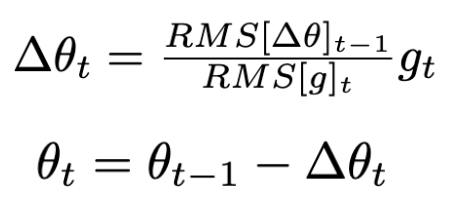

In [19]:
class AdaDelta(Optimizer):
    def __init__(self, params, eta=1e-8, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.gamma = gamma
        self.Eg = [torch.zeros_like(p) for p in self.params]
        self.Ed = [torch.zeros_like(p) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.Eg[i] = self.gamma * self.Eg[i] + (1 - self.gamma) * p.grad**2
                delta_p = torch.sqrt(self.Ed[i] + self.eta) / torch.sqrt(self.Eg[i] + self.eta) * p.grad
                p -= delta_p
                self.Ed[i] = self.gamma * self.Ed[i] + (1 - self.gamma) * delta_p**2

#### Adam
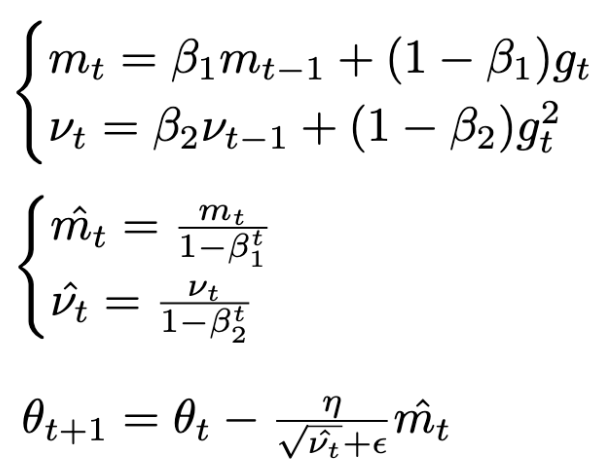

In [21]:
class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, b1=0.9, b2=0.999, epsilon=1e-8):
        super().__init__(params)
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.epsilon = epsilon
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.m[i] = self.b1 * self.m[i] + (1 - self.b1) * p.grad
                self.v[i] = self.b2 * self.v[i] + (1 - self.b2) * p.grad**2
                m_hat = self.m[i] / (1 - self.b1**self.t)
                v_hat = self.v[i] / (1 - self.b2**self.t)
                p -= self.lr * m_hat / (torch.sqrt(v_hat) + self.epsilon)

### 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [23]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), AdaDelta, {'eta': 1e-8}, start_point=[-4, -4], num_iter=100)

In [198]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {}],
        ['Momentum', Momentum, {}], 
        ['AdaGrad', AdaGrad, {}],
        ['AdaDelta', AdaDelta, {}],
        ['Adam', Adam, {}]
    ],
    start_point=[-4, -4],
    num_iter=100
)

#### Баз правильной настройки гиперпараметров не все методы сходятся

In [24]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 0.2}],
        ['Momentum', Momentum, {'lr': 0.05, 'gamma': 0.7}], 
        ['AdaGrad', AdaGrad, {'epsilon': 1, 'eta': 2}],
        ['AdaDelta', AdaDelta, {'eta': 0.1, 'gamma': 0.8}],
        ['Adam', Adam, {'lr': 1, 'b1': 0.7, 'b2': 0.99}]
    ],
    start_point=[-4, -4],
    num_iter=100
)

#### Для каждого алгоритма удалось подобрать гиперпараметры, так, что они быстро сходятся

##  Часть 2: Обучение нейронной сети

### 2.1 Реализуйте сверточную нейронную сеть и обучите ее на MNIST с помощью методов Adam, Adagrad, AdaDelta и SGD. Для обучения используйте оптимизаторы из первой части, а не из pytorch. **(2 балла)**

Скачайте датасет и реализуйте даталоудеры:

In [46]:
'''
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz
'''

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


In [56]:
'''
import urllib.request

url = "http://www.di.ens.fr/~lelarge/MNIST.tar.gz"
filename = "MNIST.tar.gz"
urllib.request.urlretrieve(url, filename)
print(f"Файл {filename} успешно загружен.")
'''

Файл MNIST.tar.gz успешно загружен.


In [58]:
'''
import tarfile

with tarfile.open("MNIST.tar.gz", "r:gz") as tar:
    tar.extractall()
    print("Архив успешно распакован.")
'''

C:\Users\baben_bakg1j1\AppData\Local\Temp\ipykernel_2664\1365058967.py:4: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Архив успешно распакован.


In [202]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Реализуйте сверточную нейронную нейронную сеть по шаблону:

* Используйте сверточные (nn.Conv2d) и полносвязные (nn.Linear) слои
* Не забудьте преобразовать тензор перед подачей в полносвязный слой (x = x.view(-1, d1), где d1 -- размерность входа первого полносвязного слоя)
* Можно использовать dropout (nn.Dropout2d) и функции активации (например, F.relu)
* В конце метода forward необходимо использовать F.log_softmax для предсказания класса изображения

In [205]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)  

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [207]:
def train_and_evaluate(network, optimizer, train_loader, test_loader, num_epochs=10):
    losses = []
    test_losses = []
    accuracies = []

    for epoch in range(1, num_epochs + 1):
        network.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = network(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
                losses.append(loss.item())

        test_loss, accuracy = test_model(network, test_loader)
        test_losses.append(test_loss)
        accuracies.append(accuracy)

        print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%\n')

    plt.figure(figsize=(12, 10))
    plt.plot(losses, label='Loss')
    plt.title("График изменения лосса")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return losses


def test_model(network, test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, accuracy


In [209]:
network = Net()

Запустите обучение, постройте график лоссов от эпохи:

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298050
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.129996
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.090345
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.067191
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.086764
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.045203
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.090447
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.057637
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.060970
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.218421
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.161440
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.019150
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.028398
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.195958
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.018428
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.127364
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.181490
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.001376
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.011972

Test set: Average loss: 0.0481, Accuracy: 98.41%

Train Ep

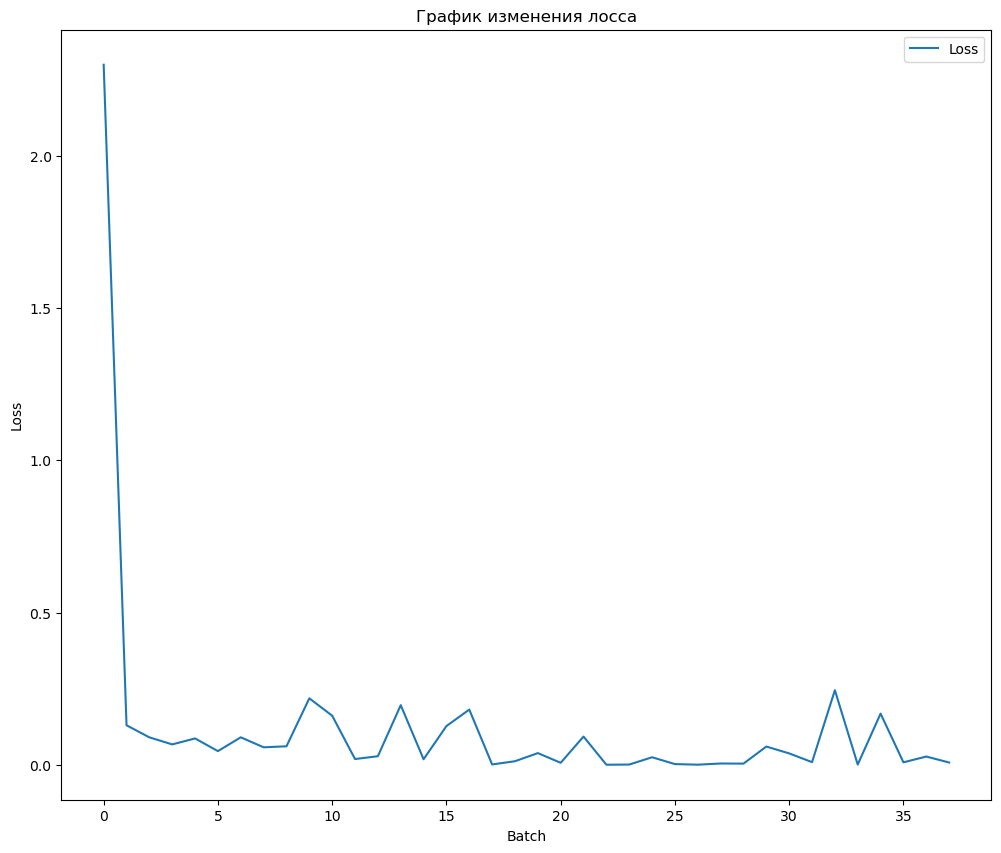

In [230]:
network = Net()
optimizer_adam = Adam(network.parameters())
adam_loss = train_and_evaluate(network, optimizer_adam, train_loader, test_loader, num_epochs=2)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317291
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.127161
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.062142
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.042432
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.089225
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.184059
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.190944
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.169838
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.047830
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.077105
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.010468
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.014679
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.014085
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.032634
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.080234
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.024830
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.266141
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.018717
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.055958

Test set: Average loss: 0.0450, Accuracy: 98.54%

Train Ep

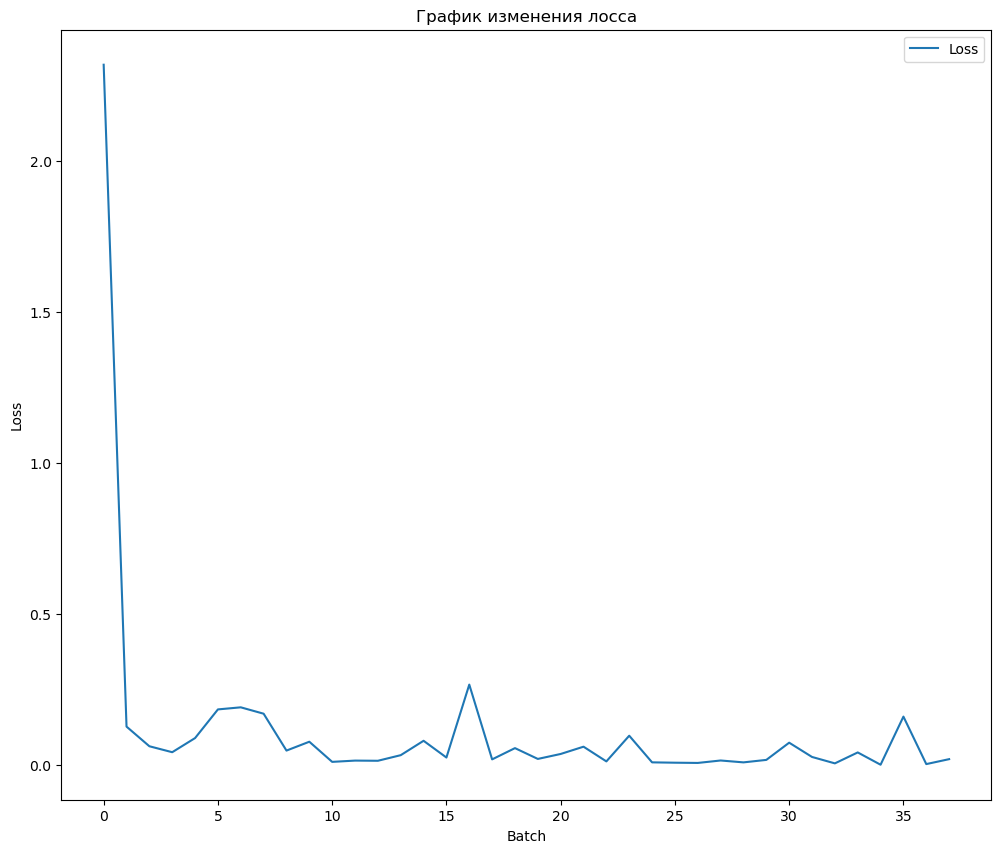

In [231]:
network = Net()
optimizer_adaGrad = AdaGrad(network.parameters())
adaGrad_loss = train_and_evaluate(network, optimizer_adaGrad, train_loader, test_loader, num_epochs=2)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.291424
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.057247
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.215852
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.054962
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.040748
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.271339
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.148640
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.042724
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.118080
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.172994
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.066205
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.006376
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.120223
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.059204
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.010206
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.057012
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.133264
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.025475
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.008777

Test set: Average loss: 0.0677, Accuracy: 97.83%

Train Ep

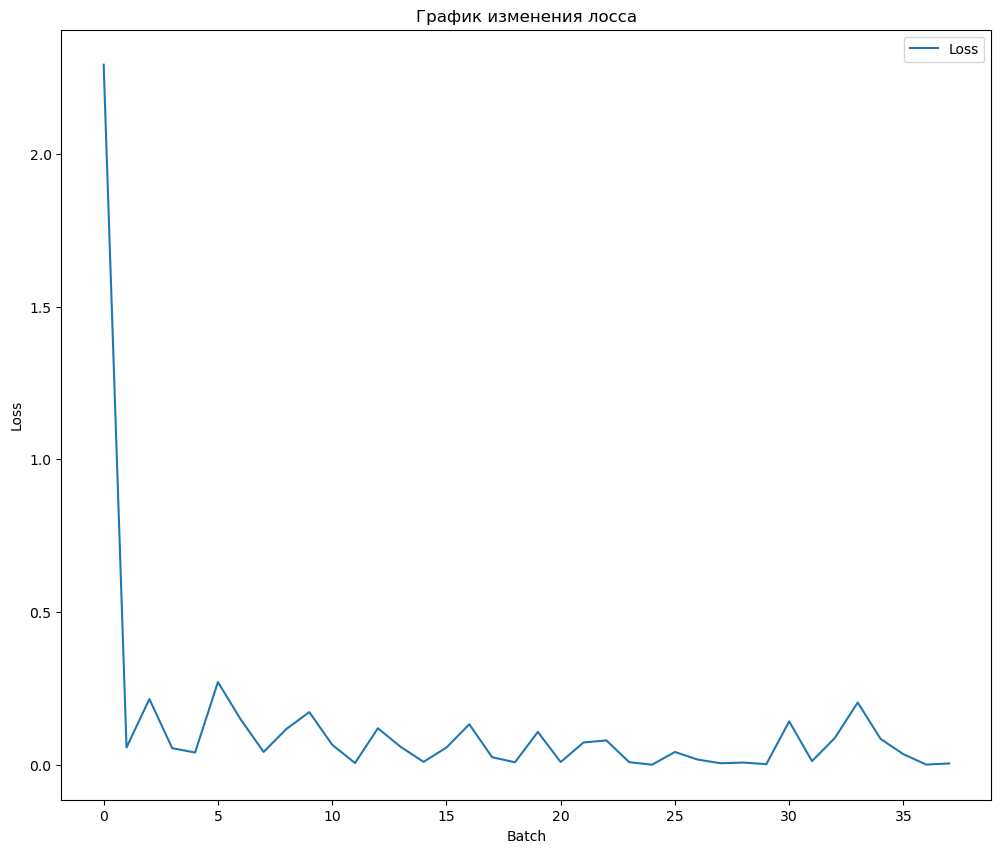

In [232]:
network = Net()
optimizer_adaDelta = AdaDelta(network.parameters())
adaDelta_loss = train_and_evaluate(network, optimizer_adaDelta, train_loader, test_loader, num_epochs=2)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310083
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.577797
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.413183
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.439665
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.277347
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.396986
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.421834
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.215254
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.104257
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.167147
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.143868
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.523089
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.144975
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.044817
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.295926
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.130360
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.194933
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.317892
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.020513

Test set: Average loss: 0.1313, Accuracy: 96.12%

Train Ep

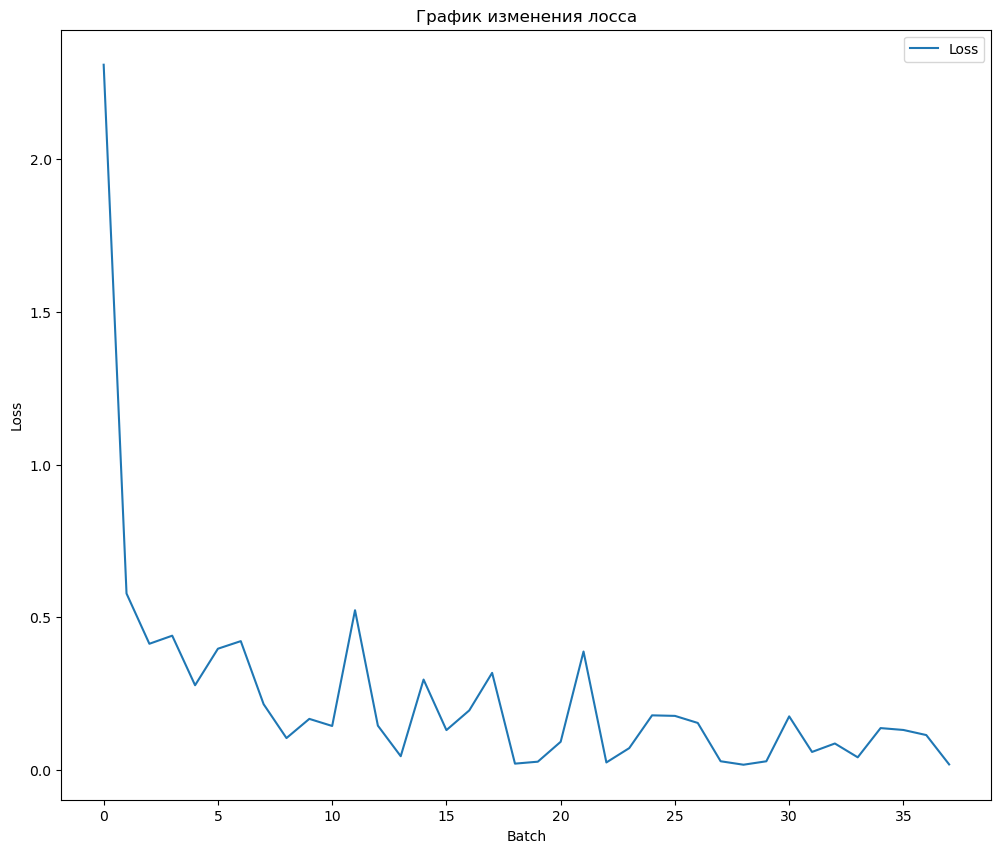

In [228]:
network = Net()
optimizer_sgd = SGD(network.parameters())
sgd_loss = train_and_evaluate(network, optimizer_sgd, train_loader, test_loader, num_epochs=2)

### 2.2 Сравните графики обучения для нейросети на методах Adam, Adagrad, AdaDelta и SGD. **(1 балл)**

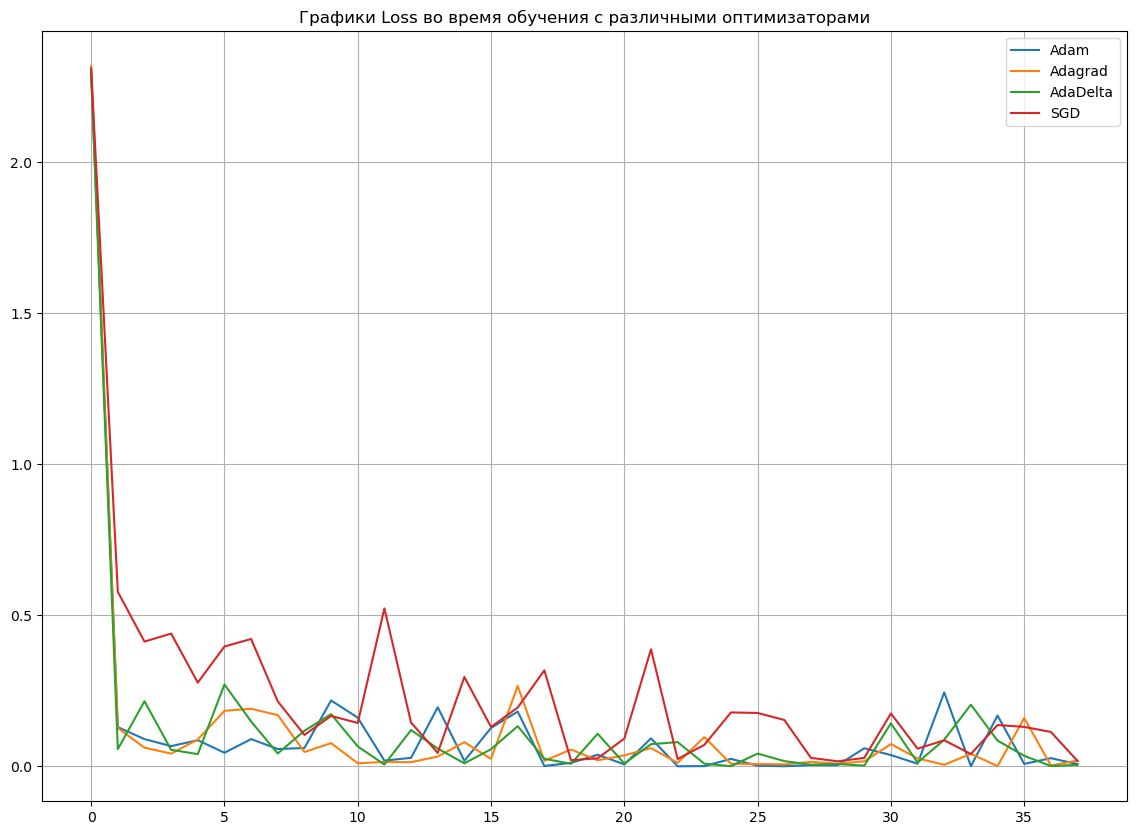

In [233]:
plt.figure(figsize=(14, 10))
plt.plot(adam_loss, label='Adam')
plt.plot(adaGrad_loss, label='Adagrad')
plt.plot(adaDelta_loss, label='AdaDelta')
plt.plot(sgd_loss, label='SGD')
plt.title("Графики Loss во время обучения с различными оптимизаторами")
plt.legend()
plt.grid()
plt.show()

#### Все методы оптимизации справились отлично
#### Несколько хуже остальных повел себя SGD

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару:

**Все понравилось**